### European Soccer

#### Objective: Build a predictive model for soccer outcomes (i.e. win/loss/tie) that out-performs the base case and approaches or surpasses the experts.


#### Potential predictors to use:

1.) Home Team Historic Win % (Last 1 Wk, Last 2 Wks, Last yr, etc...)

2.) Away Team Historic Win % 

3.) Home Total Player Rating

4.) Away Total Player Rating

5.) Historic Matchup Outcome (i.e. between specific teams)

6.) Home Field Advantage

7.) Bookie Predictions (?)

    -> Potentially grade each bookie and weight their predictions based on historical success similar to Turk HW

#### Compare Model Results Against:

1.) Actual Outcomes

2.) Aggregate Bookie Odds

#### Eliminate from data:

1.) Formations

2.) Detailed in game statistics (i.e. corners, shots on goal, fouls, etc...) (?)

2.) All player ratings but the Overall Rating (?)

In [2]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [37]:
with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    player = pd.read_sql_query("SELECT * from Player", con)
    playerstats = pd.read_sql_query("SELECT * from Player_Stats", con)

In [38]:
#Pull in countries, leagues & teams from other data tables
countries = countries.set_index('id')
leagues = leagues.set_index('id')
teams = teams.set_index('team_api_id')

matches['country'] = matches['country_id'].map(countries['name'])
matches['league'] = matches['league_id'].map(leagues['name'])
matches['home_team'] = matches['home_team_api_id'].map(teams['team_long_name'])
matches['away_team'] = matches['away_team_api_id'].map(teams['team_long_name'])

In [39]:
def get_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'home'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'away'
    else:
        return 'tie'

matches['winner'] = matches.apply(lambda row: get_winner(row), axis = 1)
matches.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBD,GBA,BSH,BSD,BSA,country,league,home_team,away_team,winner
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,Genk,Beerschot AC,tie
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,Zulte-Waregem,Lokeren,tie
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,NaN,NaN,NaN,NaN,NaN,Belgium,Belgium Jupiler League,Cercle Bruges,Anderlecht,away
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,5.50,1.44,3.75,6.50,Belgium,Belgium Jupiler League,Gent,Mons,home
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.50,1.65,4.75,3.30,1.67,Belgium,Belgium Jupiler League,FCV Dender EH,Standard Liege,away


In [40]:
#Drop Key IDs, player position columns and in-game statistics (i.e. shots, fouls, crosses, etc...) as out of scope of analysis
matches = matches.drop(matches.columns[77:85], axis = 1)
matches = matches.drop(matches.columns[11:55], axis = 1)
matches = matches.drop(matches.columns[[0,1,2,6,7,8]], axis = 1)

matches.columns.values

array(['season', 'stage', 'date', 'home_team_goal', 'away_team_goal',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH',
       'BSD', 'BSA', 'country', 'league', 'home_team', 'away_team',
       'winner'], dtype=object)

In [41]:
"""
Detailed attributes from the EA Sports FIFA video game series. Players stats are updated frequently and paint 
a fairly accurate picture of the player's skillset. Unlike Baseball, soccer doesn't have a lot of consistent statistics to measure 
actual performance on the field, but this is a decent proxy (though obviously subject to the biases of the EA Sports team 
assessing player's ratings)
"""
playerstats.head(5)

,id,player_fifa_api_id,player_api_id,date_stat,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [42]:
matches.tail()

,season,stage,date,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,...,GBD,GBA,BSH,BSD,BSA,country,league,home_team,away_team,winner
25940,2015/2016,9,2015-09-22 00:00:00,1,0,42231.0,678384.0,95220.0,638592.0,413155.0,...,NaN,NaN,NaN,NaN,NaN,Switzerland,Switzerland Super League,St. Gallen,Thun,home
25941,2015/2016,9,2015-09-23 00:00:00,1,2,33272.0,41621.0,25813.0,257845.0,114735.0,...,NaN,NaN,NaN,NaN,NaN,Switzerland,Switzerland Super League,FC Vaduz,Luzern,away
25942,2015/2016,9,2015-09-23 00:00:00,2,0,157856.0,274779.0,177689.0,294256.0,42258.0,...,NaN,NaN,NaN,NaN,NaN,Switzerland,Switzerland Super League,Grasshopper,Sion,home
25943,2015/2016,9,2015-09-22 00:00:00,0,0,NaN,8881.0,173534.0,39646.0,282287.0,...,NaN,NaN,NaN,NaN,NaN,Switzerland,Switzerland Super League,Lugano,FC Zuerich,tie
25944,2015/2016,9,2015-09-23 00:00:00,4,3,274787.0,492132.0,108451.0,25815.0,94553.0,...,NaN,NaN,NaN,NaN,NaN,Switzerland,Switzerland Super League,Young Boys,Basel,home


In [15]:
#list of unique players and attributes
player.head(5)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [16]:
matches.columns.values

array(['season', 'stage', 'date', 'home_team_goal', 'away_team_goal',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH',
       'BSD', 'BSA', 'country', 'league', 'home_team', 'away_team',
       'winner'], dtype=object)

In [17]:
base_total_win_counts = matches.groupby(('season', 'winner', 'home_team', 'away_team'))['winner'].count()

#gets total number of matches
total_matches = matches['winner'].value_counts().sum()

#gets total number of home team wins, away team wins, and ties
base_win_counts = matches['winner'].value_counts()

print "Here are the total win counts for all teams: "
print base_win_counts
print "Here are the total number of matches: ", total_matches

Here are the total win counts for all teams: 
home    11898
away     7457
tie      6590
Name: winner, dtype: int64
Here are the total number of matches:  25945


In [18]:
total_win_percents = matches.groupby(('season'))['winner'].agg("value_counts","sum")
result = total_win_percents.to_frame(name='winpercents')
result[:30]



winpercents
season    winner             
2008/2009 home       0.470836
          away       0.279314
          tie        0.249850
2009/2010 home       0.474303
          away       0.273684
          tie        0.252012
2010/2011 home       0.466258
          away       0.276380
          tie        0.257362
2011/2012 home       0.464218
          away       0.280917
          tie        0.254865
2012/2013 home       0.442945
          away       0.295399
          tie        0.261656
2013/2014 home       0.463061
          away       0.294195
          tie        0.242744
2014/2015 home       0.449323
          away       0.295038
          tie        0.255639
2015/2016 home       0.438665
          away       0.304269
          tie        0.257066

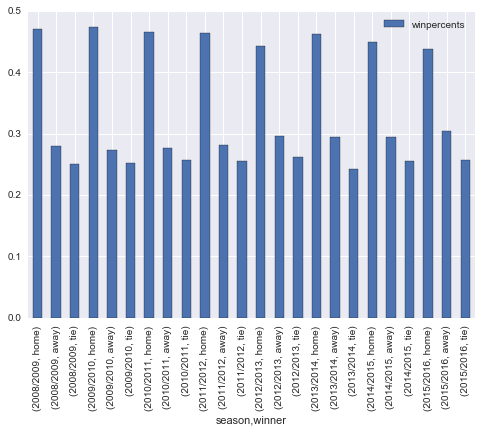

In [19]:
#reset index so that we can plot this relationship
total_win_percents_Rindex = result.reset_index()
result.plot(kind='bar')

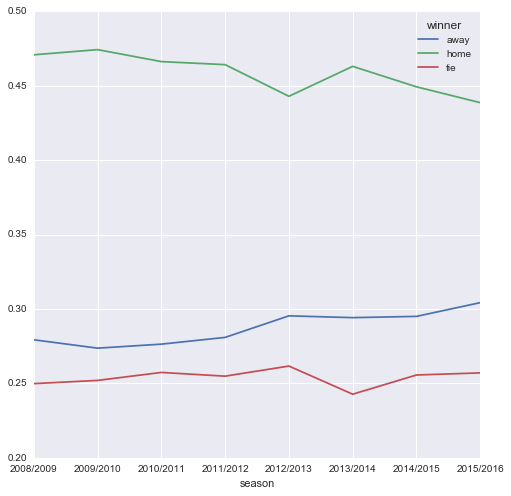

In [21]:
base_wins_over_time = pd.pivot_table(total_win_percents_Rindex,
                                 index='season',
                                 columns='winner',
                                 values='winpercents')

base_wins_over_time.ix[base_wins_over_time.index[:5], base_wins_over_time.columns[:5]]

base_wins_over_time.plot(figsize=(8,8))

In [22]:
league_win_percents = matches.groupby(('league'))['winner'].agg("value_counts","sum")
league_result = league_win_percents.to_frame(name='winpercents')
league_win_percents_Rindex = league_result.reset_index()
league_win_percents_Rindex[:30]

,league,winner,winpercents
0,Belgium Jupiler League,home,0.468750
1,Belgium Jupiler League,away,0.285301
2,Belgium Jupiler League,tie,0.245949
3,England Premier League,home,0.456088
4,England Premier League,away,0.285429
5,England Premier League,tie,0.258483
6,France Ligue 1,home,0.447039
7,France Ligue 1,tie,0.282566
8,France Ligue 1,away,0.270395
9,Germany 1. Bundesliga,home,0.452206


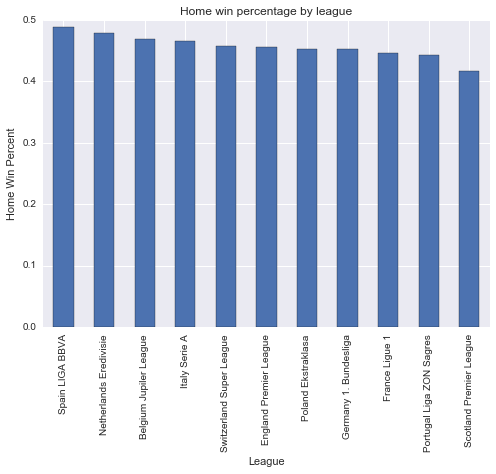

In [25]:
mask = league_win_percents_Rindex['winner'] == 'home'
league_win_percents_Rindex = league_win_percents_Rindex[mask]
league_win_percents_Rindex = league_win_percents_Rindex.set_index(league_win_percents_Rindex['league'])
Hwpbl = league_win_percents_Rindex['winpercents'].sort_values(ascending=False).plot(kind='bar', title = "Home win percentage by league", y = 'Win Percentage', x = 'League')
Hwpbl.set_xlabel("League")
Hwpbl.set_ylabel("Home Win Percent")
Hwpbl

In [183]:

j[['winner', 'B365H', 'B365D', 'B365A', 'B365_Prediction']][:10]

,winner,B365H,B365D,B365A,B365_Prediction
0,tie,1.73,3.40,5.00,home
1,tie,1.95,3.20,3.60,home
3,home,1.44,3.75,7.50,home
4,away,5.00,3.50,1.65,away
5,tie,4.75,3.40,1.67,away
6,tie,2.10,3.20,3.30,home
7,away,3.20,3.40,2.20,away
8,home,2.25,3.25,2.88,home
9,home,1.30,5.25,9.50,home
10,away,1.30,5.25,9.50,home


In [157]:
def betting_accuracy(row):
    if row['B365H'] <= row['B365D'] and row['B365H'] <= row['B365A']:
        return 'home'
    elif row['B365A'] < row['B365H'] and row['B365A'] <= row['B365D']:
        return 'away'
    elif row['B365D'] < row['B365A'] and row['B365D'] < row['B365H']:
        return 'tie'
    else:
        return 'nothing'
    
matches['B365_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['B365_Prediction']
v = matches[masky]
mask1 = matches['B365H'].notnull()
mask2 = matches['B365D'].notnull()
mask3 = matches['B365A'].notnull()
j = matches[mask1 & mask2 & mask3]
B365 = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", B365, "% for Bet365"

The percent accuracy is 53.3463779072 % for Bet365


In [135]:
def betting_accuracy(row):
    if row['BSH'] <= row['BSD'] and row['BSH'] <= row['BSA']:
        return 'home'
    elif row['BSA'] < row['BSH'] and row['BSA'] <= row['BSD']:
        return 'away'
    elif row['BSD'] < row['BSA'] and row['BSD'] < row['BSH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['BS_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['BS_Prediction']
v = matches[masky]
mask1 = matches['BSH'].notnull()
mask2 = matches['BSD'].notnull()
mask3 = matches['BSA'].notnull()
j = matches[mask1 & mask2 & mask3]
BS = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", BS, "% for Blue Square"

The percent accuracy is 53.2736827155 % for Blue Square


In [136]:
def betting_accuracy(row):
    if row['BWH'] <= row['BWD'] and row['BWH'] <= row['BWA']:
        return 'home'
    elif row['BWA'] < row['BWH'] and row['BWA'] <= row['BWD']:
        return 'away'
    elif row['BWD'] < row['BWA'] and row['BWD'] < row['BWH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['BW_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['BW_Prediction']
v = matches[masky]
mask1 = matches['BWH'].notnull()
mask2 = matches['BWD'].notnull()
mask3 = matches['BWA'].notnull()
j = matches[mask1 & mask2 & mask3]
BW = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", BW, "% for Bet&Win"

The percent accuracy is 53.1686693369 % for Bet&Win


In [138]:
def betting_accuracy(row):
    if row['GBH'] <= row['GBD'] and row['GBH'] <= row['GBA']:
        return 'home'
    elif row['GBA'] < row['GBH'] and row['GBA'] <= row['GBD']:
        return 'away'
    elif row['GBD'] < row['GBA'] and row['GBD'] < row['GBH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['GB_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['GB_Prediction']
v = matches[masky]
mask1 = matches['GBH'].notnull()
mask2 = matches['GBD'].notnull()
mask3 = matches['GBA'].notnull()
j = matches[mask1 & mask2 & mask3]
GB = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", GB, "% for GameBookers"

The percent accuracy is 53.3267059575 % for GameBookers


In [140]:
def betting_accuracy(row):
    if row['IWH'] <= row['IWD'] and row['IWH'] <= row['IWA']:
        return 'home'
    elif row['IWA'] < row['IWH'] and row['IWA'] <= row['IWD']:
        return 'away'
    elif row['IWD'] < row['IWA'] and row['IWD'] < row['IWH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['IW_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['IW_Prediction']
v = matches[masky]
mask1 = matches['IWH'].notnull()
mask2 = matches['IWD'].notnull()
mask3 = matches['IWA'].notnull()
j = matches[mask1 & mask2 & mask3]
IW = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", IW, "% for Interwetten"


The percent accuracy is 53.1742136962 % for Interwetten


In [141]:
def betting_accuracy(row):
    if row['LBH'] <= row['LBD'] and row['LBH'] <= row['LBA']:
        return 'home'
    elif row['LBA'] < row['LBH'] and row['LBA'] <= row['LBD']:
        return 'away'
    elif row['LBD'] < row['LBA'] and row['LBD'] < row['LBH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['LB_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['LB_Prediction']
v = matches[masky]
mask1 = matches['LBH'].notnull()
mask2 = matches['LBD'].notnull()
mask3 = matches['LBA'].notnull()
j = matches[mask1 & mask2 & mask3]
LB = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", LB, "% for Ladbrokes"

The percent accuracy is 53.1602155806 % for Ladbrokes


In [142]:
def betting_accuracy(row):
    if row['PSH'] <= row['PSD'] and row['PSH'] <= row['PSA']:
        return 'home'
    elif row['PSA'] < row['PSH'] and row['PSA'] <= row['PSD']:
        return 'away'
    elif row['PSD'] < row['PSA'] and row['PSD'] < row['PSH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['PS_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['PS_Prediction']
v = matches[masky]
mask1 = matches['PSH'].notnull()
mask2 = matches['PSD'].notnull()
mask3 = matches['PSA'].notnull()
j = matches[mask1 & mask2 & mask3]
PS = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", PS, "% for Pinnacle Sports"

The percent accuracy is 52.6812180005 % for Pinnacle Sports


In [153]:
def betting_accuracy(row):
    if row['SJH'] <= row['SJD'] and row['SJH'] <= row['SJA']:
        return 'home'
    elif row['SJA'] < row['SJH'] and row['SJA'] <= row['SJD']:
        return 'away'
    elif row['SJD'] < row['SJA'] and row['SJD'] < row['SJH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['SJ_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['SJ_Prediction']
v = matches[masky]
mask1 = matches['SJH'].notnull()
mask2 = matches['SJD'].notnull()
mask3 = matches['SJA'].notnull()
j = matches[mask1 & mask2 & mask3]
SJ = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", SJ, "% for Stan James"

The percent accuracy is 53.3674489736 % for Stan James


In [155]:
def betting_accuracy(row):
    if row['VCH'] <= row['VCD'] and row['VCH'] <= row['VCA']:
        return 'home'
    elif row['VCA'] < row['VCH'] and row['VCA'] <= row['VCD']:
        return 'away'
    elif row['VCD'] < row['VCA'] and row['VCD'] < row['VCH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['VC_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['VC_Prediction']
v = matches[masky]
mask1 = matches['VCH'].notnull()
mask2 = matches['VCD'].notnull()
mask3 = matches['VCA'].notnull()
j = matches[mask1 & mask2 & mask3]
VC = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", VC, "% for VC Bet"

The percent accuracy is 53.3054356052 % for VC Bet


In [156]:
def betting_accuracy(row):
    if row['WHH'] <= row['WHD'] and row['WHH'] <= row['WHA']:
        return 'home'
    elif row['WHA'] < row['WHH'] and row['WHA'] <= row['WHD']:
        return 'away'
    elif row['WHD'] < row['WHA'] and row['WHD'] < row['WHH']:
        return 'tie'
    else:
        return 'nothing'
    
matches['WH_Prediction'] = matches.apply(lambda row: betting_accuracy(row), axis=1)

masky = matches['winner'] == matches['WH_Prediction']
v = matches[masky]
mask1 = matches['WHH'].notnull()
mask2 = matches['WHD'].notnull()
mask3 = matches['WHA'].notnull()
j = matches[mask1 & mask2 & mask3]
WH = (float(len(v))/float(len(j))*100)
print "The percent accuracy is", WH, "% for WilliamHill"

The percent accuracy is 53.1603311671 % for WilliamHill


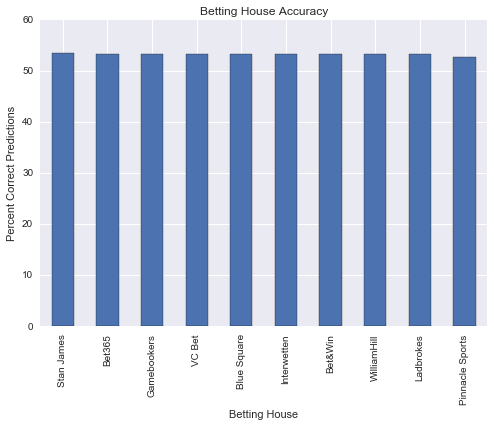

In [182]:
BettinghouseAccuracy = [B365, BS, BW, GB, IW, LB, PS, SJ, VC, WH]
Bettinghousenames = ['Bet365', 'Blue Square', 'Bet&Win', 'Gamebookers', 'Interwetten', 'Ladbrokes', 'Pinnacle Sports', 
                    'Stan James', 'VC Bet', 'WilliamHill']

df = pd.DataFrame({'Accuracy':BettinghouseAccuracy, 'Betting House':Bettinghousenames})
df = df.set_index(df['Betting House'])
df = df['Accuracy'].sort_values(ascending=False)

BettingHouseAccuracyPlot = df.plot(kind='bar', title = 'Betting House Accuracy')
BettingHouseAccuracyPlot.set_xlabel("Betting House")
BettingHouseAccuracyPlot.set_ylabel("Percent Correct Predictions")
BettingHouseAccuracyPlot